In [1]:
from copy import deepcopy

import numpy as np

from astropy import units as u
from astropy import modeling
from astropy.coordinates import SkyCoord

import gwcs
import asdf
import jwst
import jwst.datamodels

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from astropy import visualization

In [3]:
# to 
fn = 'jw10002001001_01101_00001_nrcb1_cal.fits'

# All the different ways to load... 

In [40]:
jmod = jwst.datamodels.open(fn)
jmod

<ImageModel(2048, 2048) from jw10002001001_01101_00001_nrcb1_cal.fits>

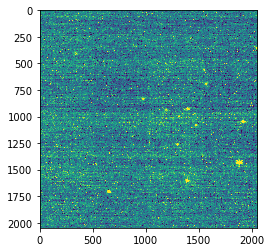

In [75]:
plt.imshow(jmod.data, norm=visualization.simple_norm(jmod.data, percent=99))

In [6]:
a = asdf.open(fn)
a

A bit surprising this isn't quite the same?

In [7]:
jfromad = jwst.datamodels.open(a)
assert np.all(jfromad.data == jmod.data)
jfromad

/Users/erik/miniconda3/envs/jwst/lib/python3.5/site-packages/jwst-0.11.0-py3.5-macosx-10.6-x86_64.egg/jwst/datamodels/util.py:163: NoTypeWarning: model_type not found. Opening model as a DataModel
  warnings.warn(errmsg, NoTypeWarning)


<DataModel from jw10002001001_01101_00001_nrcb1_cal.fits>

But this does:

In [8]:
jfromai = jwst.datamodels.ImageModel(a)
assert np.all(jfromai.data == jmod.data)
jfromai

<ImageModel(2048, 2048) from jw10002001001_01101_00001_nrcb1_cal.fits>

## Now check (asdf) round-tripping 

In [9]:
jmod.write('test.asdf')

result = jwst.datamodels.open('test.asdf')

assert np.all(result.data == jmod.data)

In [10]:
jfromad.write('test.asdf')

result = jwst.datamodels.open(asdf.open('test.asdf'))

assert np.all(result.data == jfromad.data)

ValueError: Can not parse source 'fits:VAR_POISSON,1'

In [11]:
jfromai.write('test.asdf')

result = jwst.datamodels.ImageModel(asdf.open('test.asdf'))

assert np.all(result.data == jfromai.data)

ValueError: Can not parse source 'fits:VAR_POISSON,1'

Seems like the second two should work just as well as the first...? Conunter-intuitive that there's some hidden state that seems to matter.

## Now inspect the gwcs

In [12]:
# in the future this should just be jmod.wcs :
# https://github.com/spacetelescope/jwst/pull/1026
gw = jmod.meta.wcs
gw = deepcopy(gw)  # since we're messing with it below for testing...

In [13]:
det_coordinates = (10, 20)

sc0 = gw(*det_coordinates, with_units=True)
sc0

<SkyCoord (ICRS): (ra, dec) in deg
    (53.11309935, -27.80735382)>

In [14]:
gw.pipeline.insert(2,('name', gw.pipeline[1][1]))

sc1 = gw(*det_coordinates, with_units=True)
assert sc1.separation(sc0) > 1*u.marcsec
sc1

<SkyCoord (ICRS): (ra, dec) in deg
    (53.15799585, -27.67926357)>

In [15]:
del gw.pipeline[2]

sc2 = gw(*det_coordinates, with_units=True)
assert sc2.separation(sc0) < 1*u.marcsec
sc2

<SkyCoord (ICRS): (ra, dec) in deg
    (53.11309935, -27.80735382)>

### Set up some custom models

In [16]:
class IdentTrans(modeling.Fittable2DModel):
    inputs = ('x', 'y')
    outputs = ('x1', 'y1')
    
    p = modeling.Parameter(default=1)
    
    @staticmethod
    def evaluate(x, y, p):
        return x, y
    
IdentTrans()(1, 3)

(1.0, 3.0)

In [17]:
class WeirdFlipTrans(modeling.Fittable2DModel):
    inputs = ('x', 'y')
    outputs = ('x1', 'y1')
    
    p = modeling.Parameter(default=1)
    
    @staticmethod
    def evaluate(x, y, p):
        if p>0:
            return -x, y
        else:
            return x, -y
    
WeirdFlipTrans(p=-1)(1, 3), WeirdFlipTrans(p=2)(1, 3)

((1.0, -3.0), (-1.0, 3.0))

### And apply them 

In [18]:
gw.pipeline.insert(2,('ident', IdentTrans(p=2)))

sc3 = gw(*det_coordinates, with_units=True)
assert sc3.separation(sc0) < 1*u.marcsec
sc3

<SkyCoord (ICRS): (ra, dec) in deg
    (53.11309935, -27.80735382)>

In [19]:
del gw.pipeline[2]

In [20]:
gw.pipeline.insert(2,('flip', WeirdFlipTrans(p=2)))

sc4 = gw(*det_coordinates, with_units=True)
assert sc4.separation(sc0) > 1*u.marcsec
sc4flip = SkyCoord(ra=-sc4.ra, dec=sc4.dec)
assert sc4flip.separation(sc0) < 1*u.marcsec
sc4, sc4flip

(<SkyCoord (ICRS): (ra, dec) in deg
     (306.88690065, -27.80735382)>, <SkyCoord (ICRS): (ra, dec) in deg
     (53.11309935, -27.80735382)>)

### Now insert the last one back in place 

In [21]:
jmod.meta.wcs = gw

AttributeError: 'WCS' object has no attribute 'flip'

Above would appear to be a flaw in `gwcs` - it can't handle in-place insertions *on write*.

In [33]:
orig_wcs = jmod.meta.wcs
jmod.meta.wcs = gwcs.WCS(gw.pipeline, gw.input_frame, gw.output_frame, 'test')
assert len(jmod.meta.wcs.pipeline) == 4

In [26]:
jmod.write('test.asdf')

result = jwst.datamodels.open('test.asdf')

assert np.all(result.data == jmod.data)

ValidationError: <WeirdFlipTrans(p=2.)> is not valid under any of the given schemas

Failed validating 'anyOf' in schema['properties']['steps']['items']['properties']['transform']:
    OrderedDict([('description',
                  'The transform from this step to the next one.  The\n'
                  'last step in a WCS should not have a transform, but\n'
                  'exists only to describe the frames and units of the\n'
                  'final output axes.\n'),
                 ('anyOf',
                  [OrderedDict([('$ref',
                                 'tag:stsci.edu:asdf/transform/transform-1.1.0')]),
                   OrderedDict([('type', 'null')])]),
                 ('default', None)])

On instance['steps'][2]['transform']:
    <WeirdFlipTrans(p=2.)>

Above would appear to be the flaw. Custom transforms should be possible.  Seems pretty obvious that the other two would fail the same way so no point in trying until the above works.

# To test *after* the above is fixed 

**RESTART THE KERNEL** before running the below

In [ ]:
import jwst.datamodels

In [ ]:
jmod_new = jwst.datamodels.open(fn)
sc_new = jmod_new.meta.wcs(10, 20, with_units=True)
sc_expected = SkyCoord(306.88690065*u.deg, -27.80735382*u.deg)
assert sc_new.separation(sc_expected) < 1*u.marcsec
sc_new